---
output-file: individual.html
title: DHPCTIndividual
DHPCTIndividual: Deep Hierarchical Perceptual Control Theory Individual
---


In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
#| default_exp individual


In [3]:
#|export
import gymnasium as gym
import tensorflow as tf
import numpy as np
import json


In [ ]:
#|export
class DHPCTDebugHelper:
    """
    Helper class for debugging DHPCTIndividual Keras models layer-by-layer.
    """
    def __init__(self, model):
        self.model = model

    @staticmethod
    def get_layer_name(layer):
        """Return the name of the layer."""
        return layer.name

    @staticmethod
    def get_layer_weights(layer):
        """Return the weights of the layer, or None if not applicable."""
        return layer.get_weights() if hasattr(layer, 'get_weights') else None

    @staticmethod
    def get_layer_output(layer, input_for_layer):
        """Compute and return the output of the layer for the given input."""
        try:
            # don't compute outputs get from output tensor
            print(f"  [Computing output for layer {layer.name}]")
            print(f"  [Input for layer: {input_for_layer}]")
            
            return layer(input_for_layer)
        except Exception as e:
            print(f"  [Error computing output: {e}]")
            return None

    @staticmethod
    def get_input_layer_names(layer):
        """Return a list of originating layer names for the inputs to this layer."""
        if isinstance(layer.input, list):
            names = []
            for inp in layer.input:
                if hasattr(inp, 'name'):
                    names.append(inp.name.split('/')[0])
            return names
        else:
            inp = layer.input
            if hasattr(inp, 'name'):
                return [inp.name.split('/')[0]]
            return []

    def debug_step(self, obs_input, ref_input):
        """
        Print weights, input values, and output values for each layer for a single step.
        """
        print("\nLayer-by-layer computation:")
        prev_outputs = {'Observations': obs_input, 'Reference': ref_input}
        for layer in self.model.layers:
            # Skip InputLayer and skip Observations and Reference explicitly
            if 'input' in layer.name.lower() or layer.name in ['Observations', 'Reference']:
                continue
            # Get input layer names
            input_layer_names = self.get_input_layer_names(layer)
            input_vals = [prev_outputs.get(n, None) for n in input_layer_names]
            input_vals = [v for v in input_vals if v is not None]
            if len(input_vals) == 1:
                input_for_layer = input_vals[0]
            else:
                input_for_layer = input_vals
            # Print input values
            print(f"Layer {layer.name}:")
            if isinstance(input_for_layer, list):
                for idx, val in enumerate(input_for_layer):
                    print(f"  Input {idx}: {val if isinstance(val, np.ndarray) else (val.numpy() if hasattr(val, 'numpy') else val)}")
            else:
                print(f"  Input: {input_for_layer if isinstance(input_for_layer, np.ndarray) else (input_for_layer.numpy() if hasattr(input_for_layer, 'numpy') else input_for_layer)}")
            # Print weights
            weights = self.get_layer_weights(layer)
            if weights:
                print(f"  Weights: {weights}")
            # Compute output
            out_val = self.get_layer_output(layer, input_for_layer)
            if out_val is not None:
                out_val_np = out_val if isinstance(out_val, np.ndarray) else (out_val.numpy() if hasattr(out_val, 'numpy') else out_val)
                print(f"  Output: {out_val_np}")
                prev_outputs[layer.name] = out_val
            else:
                print("  Output: [None]")


In [5]:
#|export
class DHPCTIndividual:
    """
    Represents an individual with a hierarchical PCT control system and an environment.
    """
    def __init__(self, env_name, env_props=None, levels=None, activation_funcs=None, weight_types=None, input_references=None):
        self.env_name = env_name
        self.env_props = env_props or {}
        self.levels = levels or []
        self.activation_funcs = activation_funcs or {}
        self.weight_types = weight_types or {}
        self.input_references = input_references
        self.env = None
        self.model = None
        self.weights = {}

    @classmethod
    def from_config(cls, config_dict):
        env_cfg = config_dict.get('env', {})
        hier_cfg = config_dict.get('hierarchy', {})
        weights = config_dict.get('weights', {})
        obj = cls(
            env_name=env_cfg.get('env_name'),
            env_props=env_cfg.get('properties'),
            levels=hier_cfg.get('levels'),
            activation_funcs=hier_cfg.get('activation_funcs'),
            weight_types=hier_cfg.get('weight_types'),
        )
        obj.weights = weights
        return obj

    def compile(self):
        """
        Build the environment and Keras model according to the DPCT hierarchical PCT specification and naming conventions.
        """
        if not self.levels or not isinstance(self.levels, list) or not all(isinstance(l, int) and l > 0 for l in self.levels):
            raise ValueError("'levels' must be a non-empty list of positive integers. Got: {}".format(self.levels))
        self.env = gym.make(self.env_name, **self.env_props) if self.env_props else gym.make(self.env_name)
        # Observation and action space sizes
        space = self.env.observation_space
        shape = getattr(space, 'shape', None)
        if shape is not None and len(shape) > 0:
            obs_space = shape[0]
        elif isinstance(space, gym.spaces.Discrete):
            obs_space = 1
        else:
            raise ValueError("Unsupported observation space type")
        action_space = self.env.action_space
        act_shape = getattr(action_space, 'shape', None)
        if act_shape is not None and len(act_shape) > 0:
            act_space = act_shape[0]
        elif isinstance(action_space, gym.spaces.Discrete):
            act_space = action_space.n
        else:
            act_space = 1
        # Naming conventions
        def lname(prefix, level):
            return f"{prefix}L{level:02d}"
        # Input layers
        obs_input = tf.keras.Input(shape=(obs_space,), name='Observations')
        ref_shape = (len(self.input_references),) if self.input_references is not None else (self.levels[-1],)
        ref_input = tf.keras.Input(shape=ref_shape, name='Reference')
        # Build hierarchy
        perceptions = []
        references = []
        comparators = []
        outputs = []
        act0 = self.activation_funcs.get(0, 'linear')
        p0 = tf.keras.layers.Dense(self.levels[0], use_bias=False, activation=act0, name=lname('P', 0))(obs_input)
        perceptions.append(p0)
        # Level 0 reference
        if len(self.levels) == 1:
            # For single level, use reference input as reference
            r0 = tf.keras.layers.Lambda(lambda x: x, name=lname('R', 0))(ref_input)
        else:
            # For multi-level, reference is weighted sum of output layer of level 1
            # We'll create level 1 output first, then use it for r0
            act1 = self.activation_funcs.get(1, 'linear')
            p1 = tf.keras.layers.Dense(self.levels[1], use_bias=False, activation=act1, name=lname('P', 1))(p0)
            perceptions.append(p1)
            # Reference for level 1 (top if only 2 levels, else will be overwritten in loop)
            if len(self.levels) == 2:
                r1 = tf.keras.layers.Lambda(lambda x: x, name=lname('R', 1))(ref_input)
            else:
                r1 = tf.keras.layers.Dense(self.levels[1], use_bias=False, activation='linear', name=lname('R', 1))(p0)
            references.append(r1)
            c1 = tf.keras.layers.Subtract(name=lname('C', 1))([r1, p1])
            comparators.append(c1)
            o1 = tf.keras.layers.Multiply(name=lname('O', 1))([c1, tf.keras.layers.Dense(self.levels[1], use_bias=False, activation='linear')(c1)])
            outputs.append(o1)
            # Now r0 is weighted sum of o1
            r0 = tf.keras.layers.Dense(self.levels[0], use_bias=False, activation='linear', name=lname('R', 0))(o1)
        references.insert(0, r0)
        c0 = tf.keras.layers.Subtract(name=lname('C', 0))([r0, p0])
        comparators.insert(0, c0)
        o0 = tf.keras.layers.Multiply(name=lname('O', 0))([c0, tf.keras.layers.Dense(self.levels[0], use_bias=False, activation='linear')(c0)])
        outputs.insert(0, o0)
        # Build higher levels if more than 2
        for i in range(2, len(self.levels)):
            act = self.activation_funcs.get(i, 'linear')
            p = tf.keras.layers.Dense(self.levels[i], use_bias=False, activation=act, name=lname('P', i))(perceptions[i-1])
            perceptions.append(p)
            if i == len(self.levels) - 1:
                r = tf.keras.layers.Lambda(lambda x: x, name=lname('R', i))(ref_input)
            else:
                r = tf.keras.layers.Dense(self.levels[i], use_bias=False, activation='linear', name=lname('R', i))(outputs[i-1])
            references.append(r)
            c = tf.keras.layers.Subtract(name=lname('C', i))([r, p])
            comparators.append(c)
            o = tf.keras.layers.Multiply(name=lname('O', i))([c, tf.keras.layers.Dense(self.levels[i], use_bias=False, activation='linear')(c)])
            outputs.append(o)
        actions = tf.keras.layers.Dense(act_space, use_bias=False, activation='linear', name='Actions')(outputs[0])
        errors = tf.keras.layers.Concatenate(name='Errors')(comparators) if len(comparators) > 1 else comparators[0]
        self.model = tf.keras.Model(inputs=[obs_input, ref_input], outputs=[actions, errors])

    def config(self):
        return {
            'env': {
                'env_name': self.env_name,
                'properties': self.env_props
            },
            'hierarchy': {
                'levels': self.levels,
                'activation_funcs': self.activation_funcs,
                'weight_types': self.weight_types
            },
            'weights': self.weights
        }

    def save_config(self, filepath):
        try:
            with open(filepath, 'w') as f:
                json.dump(self.config(), f, indent=2)
            return True
        except Exception:
            return False

    def debug_step(self, step, obs_input, ref_input, action):
        print(f"\n--- Step {step+1} ---")
        print(f"Observation: {obs_input}")
        print(f"Reference input: {ref_input}")

        if not hasattr(self, '_debug_helper') or self._debug_helper is None:
            self._debug_helper = DHPCTDebugHelper(self.model)
        self._debug_helper.debug_step(obs_input, ref_input)
        print(f"Action chosen: {action}")


    def run(self, steps, train=False, early_termination=False, debug=False):
        """
        Run the individual in its environment
        Parameters:
        - steps: Number of timesteps to run
        - train: Whether to enable online learning during execution
        - early_termination: Whether to terminate early based on environment signals
        - debug: If True, print weights, input values, and output values for each layer at each step
        """
        if not self.levels or len(self.levels) == 0:
            raise ValueError("Hierarchy levels are not defined. Please provide a non-empty levels list.")
        if self.env is None or self.model is None:
            self.compile()
        if self.env is None:
            raise RuntimeError("Environment is not initialized. Call compile() first.")
        if self.model is None:
            raise RuntimeError("Model is not initialized. There was an error during compile().")
        obs = self.env.reset()
        if isinstance(obs, tuple):
            obs = obs[0]
        total_reward = 0
        for step in range(steps):
            obs_input = np.expand_dims(obs, axis=0)
            ref_input = np.zeros((1, self.levels[-1])) if self.levels else np.zeros((1, 1))
            model_inputs = [obs_input, ref_input]
            model_outputs = self.model(model_inputs)
            actions = model_outputs[0].numpy().squeeze()
            if hasattr(self.env.action_space, 'n'):
                action = int(np.argmax(actions))
            else:
                action = actions
            if debug:
                self.debug_step(step, obs_input, ref_input, action)
            step_result = self.env.step(action)
            if len(step_result) == 5:
                obs, reward, terminated, truncated, _ = step_result
            else:
                obs, reward, done, _ = step_result
                terminated = done
                truncated = False
            total_reward += reward
            if early_termination and (terminated or truncated):
                break
        self.env.close()
        return total_reward

    def mate(self, other):
        """
        Create two new individuals by crossing this one with another.
        Structure is crossed over (one-point crossover), weights are blended.
        Returns:
            tuple: (child1, child2) as new DHPCTIndividual instances
        """
        import copy
        import random
        # Crossover for levels (structure): one-point crossover
        if not self.levels or not other.levels or len(self.levels) != len(other.levels):
            # fallback: just copy
            return copy.deepcopy(self), copy.deepcopy(other)
        point = random.randint(1, len(self.levels)-1)
        child1_levels = self.levels[:point] + other.levels[point:]
        child2_levels = other.levels[:point] + self.levels[point:]
        # Crossover for activation_funcs and weight_types (shallow merge)
        child1_af = {**self.activation_funcs, **{k: other.activation_funcs.get(k, v) for k, v in self.activation_funcs.items()}}
        child2_af = {**other.activation_funcs, **{k: self.activation_funcs.get(k, v) for k, v in other.activation_funcs.items()}}
        child1_wt = {**self.weight_types, **{k: other.weight_types.get(k, v) for k, v in self.weight_types.items()}}
        child2_wt = {**other.weight_types, **{k: self.weight_types.get(k, v) for k, v in other.weight_types.items()}}
        # Blend weights if present (simple average for matching keys)
        def blend_weights(w1, w2):
            if not w1 or not w2:
                return w1 or w2 or {}
            blended = {}
            for k in set(w1.keys()).union(w2.keys()):
                v1 = w1.get(k)
                v2 = w2.get(k)
                if isinstance(v1, (int, float)) and isinstance(v2, (int, float)):
                    blended[k] = (v1 + v2) / 2
                elif isinstance(v1, dict) and isinstance(v2, dict):
                    blended[k] = blend_weights(v1, v2)
                else:
                    blended[k] = v1 if v1 is not None else v2
            return blended
        child1_weights = blend_weights(self.weights, other.weights)
        child2_weights = blend_weights(other.weights, self.weights)
        # Create children
        child1 = DHPCTIndividual(
            env_name=self.env_name,
            env_props=copy.deepcopy(self.env_props),
            levels=child1_levels,
            activation_funcs=child1_af,
            weight_types=child1_wt
        )
        child2 = DHPCTIndividual(
            env_name=other.env_name,
            env_props=copy.deepcopy(other.env_props),
            levels=child2_levels,
            activation_funcs=child2_af,
            weight_types=child2_wt
        )
        child1.weights = child1_weights
        child2.weights = child2_weights
        return child1, child2

    def mutate(self, struct_prob=0.1, weight_prob=0.1):
        # Placeholder: no-op
        pass

    def evaluate(self, nevals=1):
        # Placeholder: average reward over nevals runs
        scores = [self.run(steps=200) for _ in range(nevals)]
        return np.mean(scores)


In [6]:
# Basic test: instantiate, compile, and run DHPCTIndividual
ind = DHPCTIndividual(env_name='CartPole-v1', levels=[1, 1], activation_funcs={0: 'relu', 1: 'tanh'})
ind.compile()
print('Config:', ind.config())



Config: {'env': {'env_name': 'CartPole-v1', 'properties': {}}, 'hierarchy': {'levels': [1, 1], 'activation_funcs': {0: 'relu', 1: 'tanh'}, 'weight_types': {}}, 'weights': {}}
Config: {'env': {'env_name': 'CartPole-v1', 'properties': {}}, 'hierarchy': {'levels': [1, 1], 'activation_funcs': {0: 'relu', 1: 'tanh'}, 'weight_types': {}}, 'weights': {}}


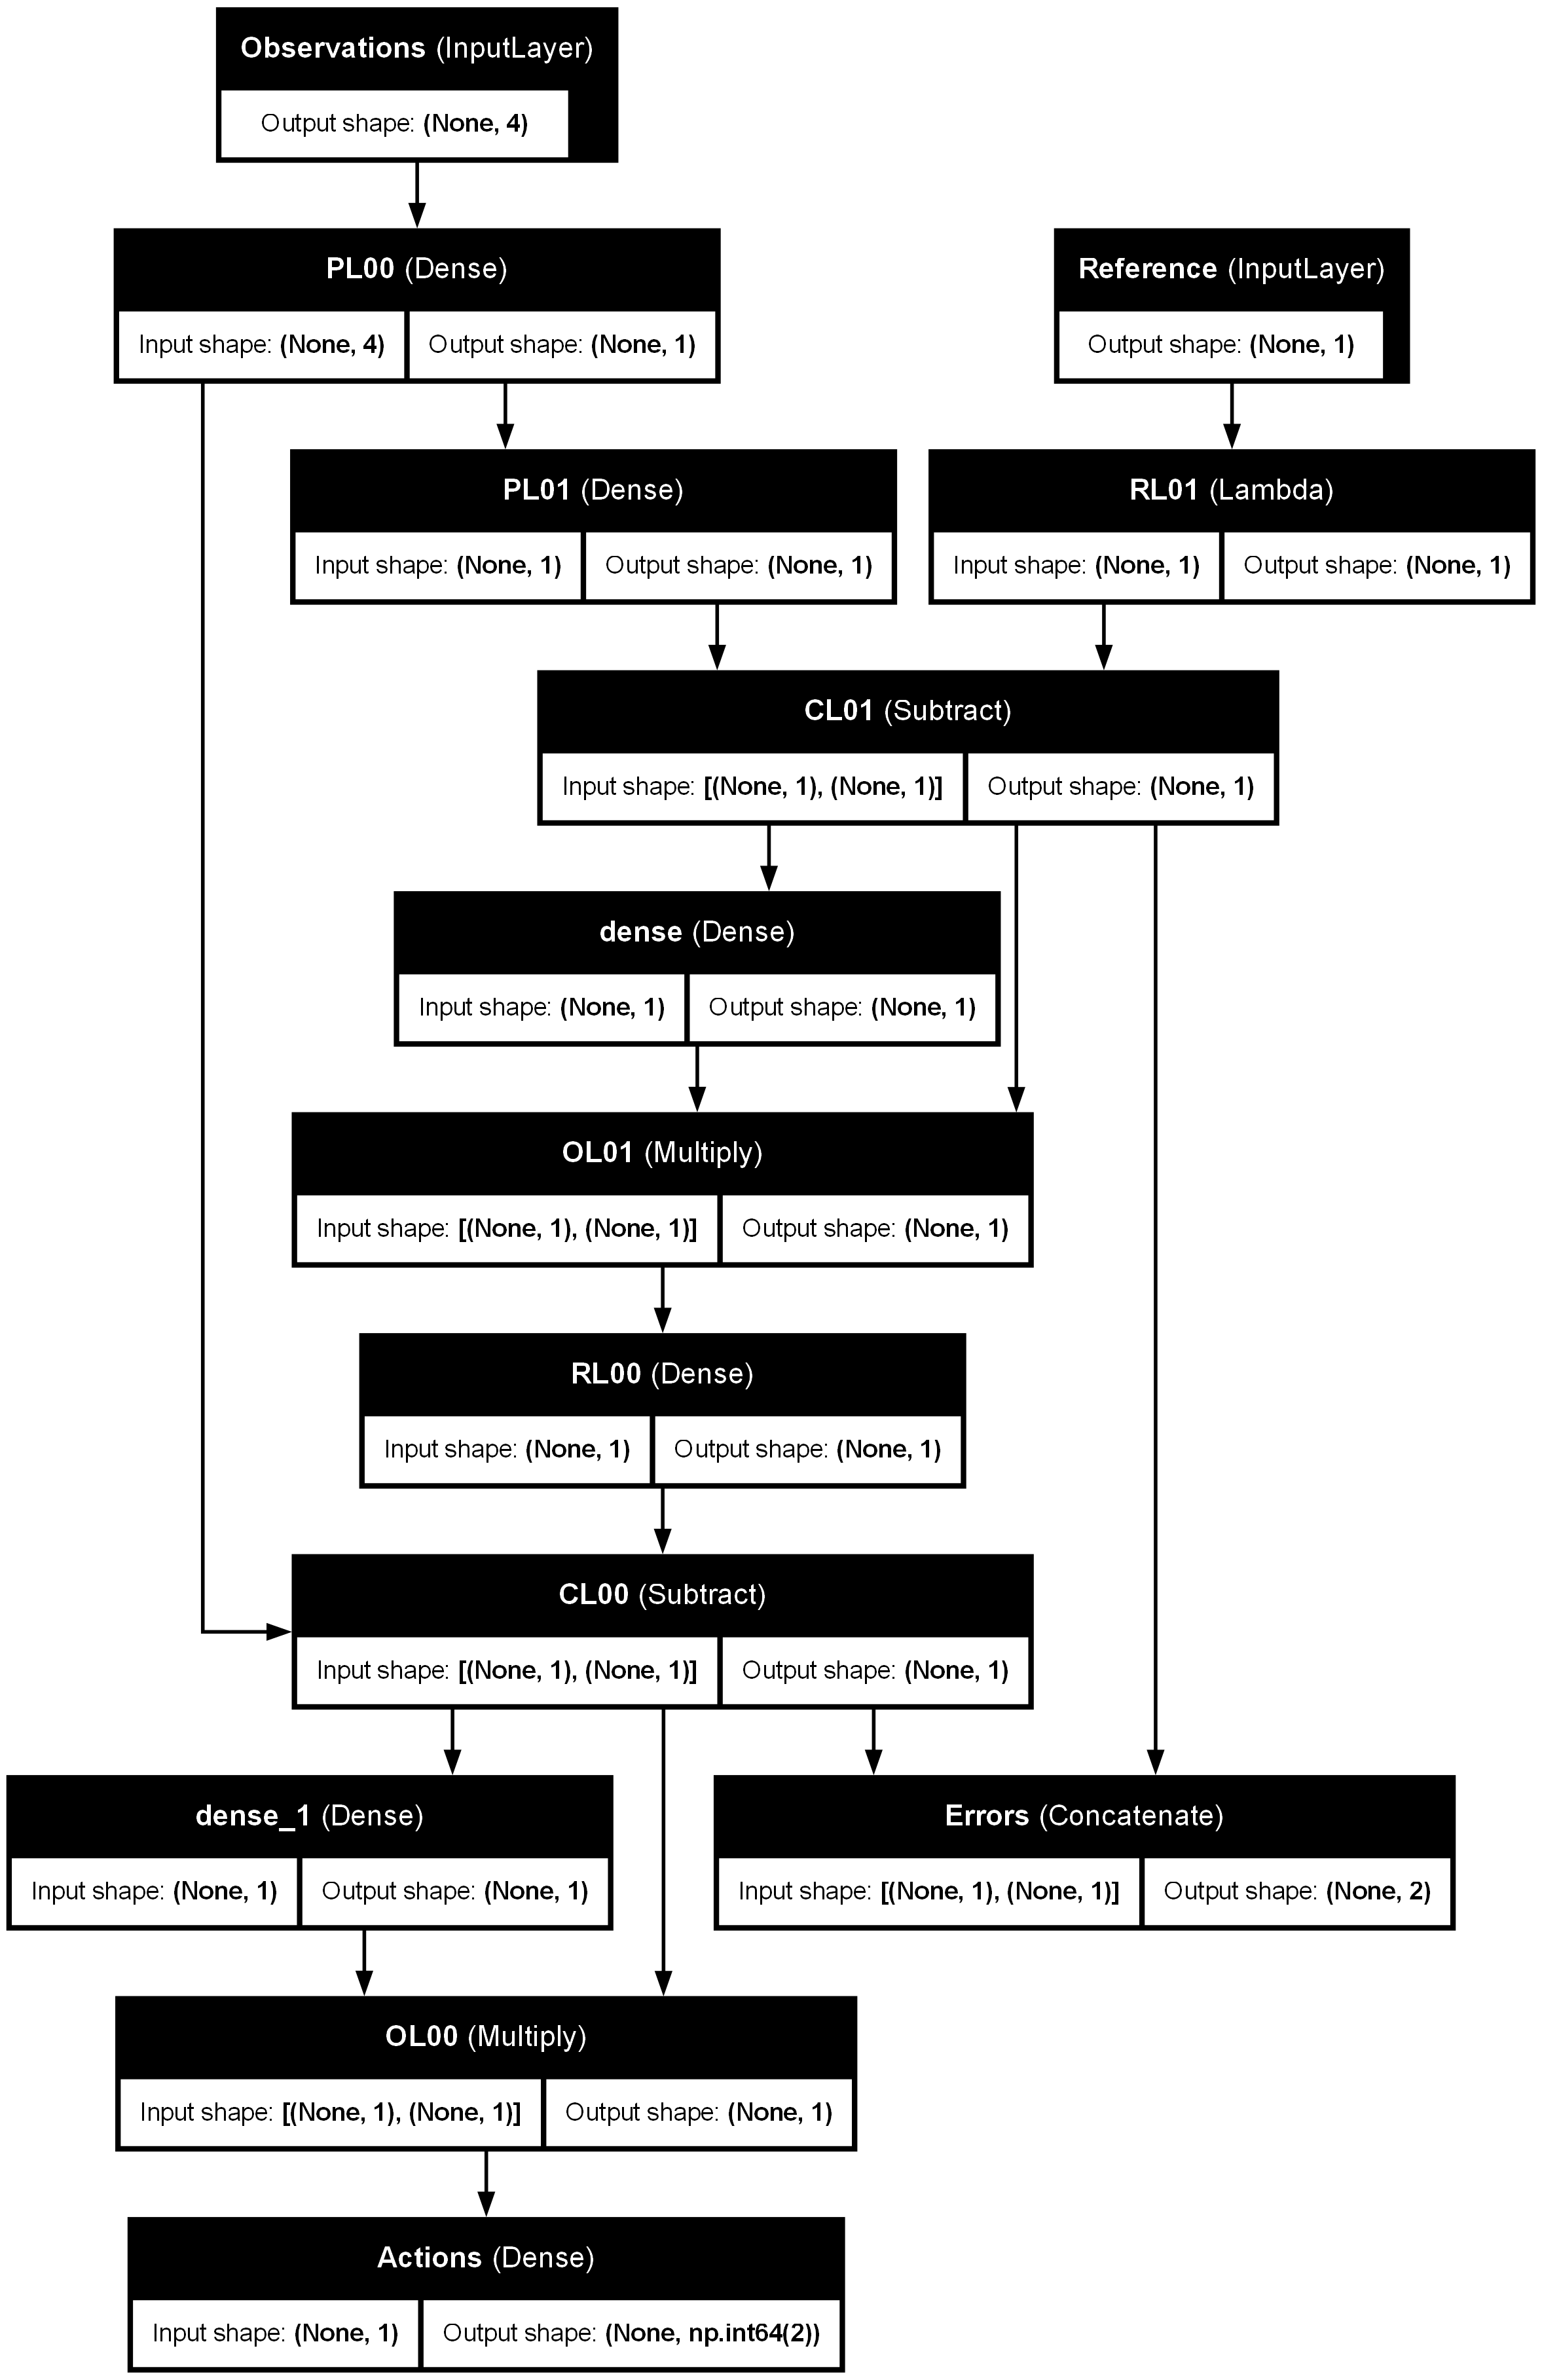

In [7]:
tf.keras.utils.plot_model(ind.model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [8]:
steps=1
result = ind.run(steps=steps, debug=True)
print(f'Total reward for {steps} steps:', result)


--- Step 1 ---
Observation: [[-0.04064756  0.04804661  0.006228    0.00496066]]
Reference input: [[0.]]

Layer-by-layer computation:
Layer PL00:
  Input: [[-0.04064756  0.04804661  0.006228    0.00496066]]
  Weights: [array([[ 0.07944536],
       [-0.60615647],
       [ 0.8316678 ],
       [ 0.04004061]], dtype=float32)]
  [Computing output for layer PL00]
  [Input for layer: [[-0.04064756  0.04804661  0.006228    0.00496066]]]
  Output: [[0.]]
Layer RL01:
  Input: [[0.]]
  [Computing output for layer RL01]
  [Input for layer: [[0.]]]
  Output: [[0.]]
Layer PL01:
  Weights: [array([[-1.1234645]], dtype=float32)]
  [Computing output for layer PL01]
  [Input for layer: []]
  [Error computing output: Layer "PL01" expects 1 input(s), but it received 0 input tensors. Inputs received: []]
  Output: [None]
Layer CL01:
  [Computing output for layer CL01]
  [Input for layer: []]
  [Error computing output: Exception encountered when calling Subtract.call().

A `Subtract` layer should be called 

In [9]:
#| hide
import nbdev; nbdev.nbdev_export()